# Simulating ancestry with msprime

10.30am

- What is msprime?
- What makes it different from other genetic simulators out there?
    - Historical connection with `ms`
    - Tree sequences
    - Forwards and backwards simulation and efficiency
	- When might you use  `msprime` over these other simulators
    

Overview of the two msprime sessions:
 -  simulating ancestry (node, edge, individuals, populations)
 -  simulating mutations (mutations, sites)
 -  discuss why these are separate

Plan for the session:
- Contigs
- Demographic history
- Models

In [2]:
import msprime
import random
from IPython.display import SVG

### Basic syntax

(10.40am)

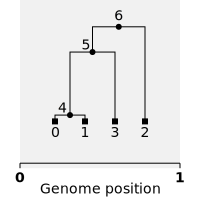

In [3]:
ts = msprime.sim_ancestry(samples=2, random_seed=1)
SVG(ts.draw_svg())

Things to note here:
 - we have a tree sequence object that consists of just a single tree, bc recombination not yet specified
 - random seed argument just used to make sure we all get the same simulation
 - samples = 2 simulates haplotypes from 2 individuals, presumed diploid by default. To specify a different ploidy use the `ploidy` argument

## Specifying contig information
 - ploidy
 - sequence length
 - discrete_genome
 - Recombination maps
      - note that gene conversion is also possible
 - Exercise
 

**Ploidy**

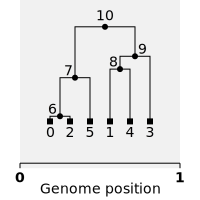

In [4]:
ts = msprime.sim_ancestry(samples=2, random_seed=1, ploidy=3)
SVG(ts.draw_svg())

**Sequence length**

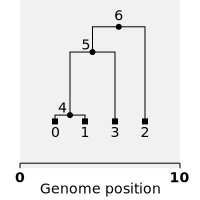

In [5]:
ts = msprime.sim_ancestry(samples=2, random_seed=1, sequence_length=10)
SVG(ts.draw_svg())

**Setting recombination rate**

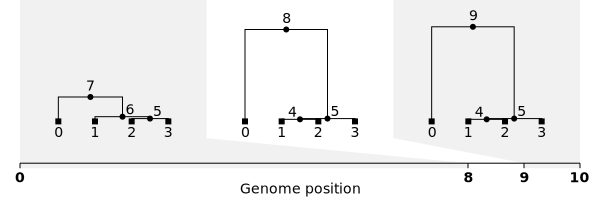

In [6]:
ts = msprime.sim_ancestry(samples=2, random_seed=1, sequence_length=10, recombination_rate=0.1)
SVG(ts.draw_svg())

**Non-uniform recombination**

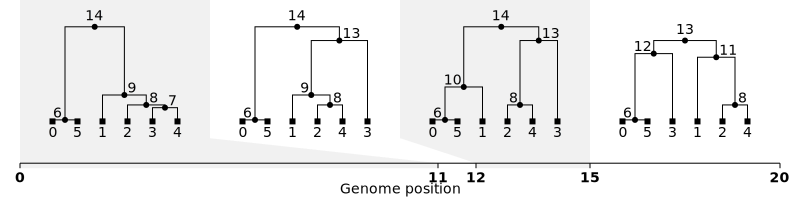

In [7]:
rate_map = msprime.RateMap(position=[0, 10, 20], rate=[0.01, 0.1])
ts = msprime.sim_ancestry(3, recombination_rate=rate_map, random_seed=2)
SVG(ts.draw_svg())

Mention that gene conversion is possible in addition to recombination -- to see how this works, see this tutorial about the `gene_conversion_rate` and `gene_conversion_tract_length` arguments.

**Discrete genome:**

by default the recombination positions will happen at integer locations, mimicking actually happens. However there may be situations where you want to model continuous genome -- eg. if you want to run a totally classical coalescent model with a infinite sites model of recombination. In this case, use `discrete_genome` argument:

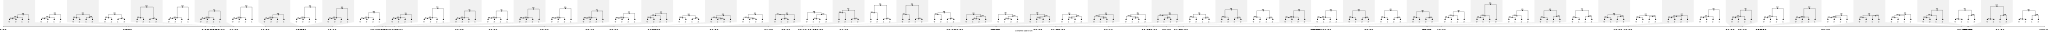

In [8]:
ts = msprime.sim_ancestry(
    samples=2, random_seed=2, sequence_length=100,
    recombination_rate=0.1, discrete_genome=False)
SVG(ts.draw_svg())

(10.55am)

*Exercise:* modify the following code to simulate chromosomes for 2 organisms of ploidy 3, with a chromosome length of 100 and a variable recombination rate with a hotspot  from coordinates 50 to 60 where the rate is 0.1.

In [ ]:
rate_map = msprime.RateMap(position=[0, 100], rate=[0.01])
ts = msprime.sim_ancestry(3, recombination_rate=rate_map, random_seed=193, ploidy=3)
SVG(ts.draw_svg())

## Demographic history

(11am)

So far we haven't really discussed the times in the branches, or the historical information. By default msprime uses population_size=1 (check: is this dependent on ploidy), which puts trees in 'coalescent time units'. (Can briefly explain why these are useful...)

However, in reality we are trying to model a species whose demographic history we know something about

So far, we have been simulating samples from a single population of a constant size, which isn’t particularly exciting! One of the strengths of msprime is that it can be used to specify quite complicated models of demography and population history with a simple Python API.

### Population structure

(11.05am)

msprime supports simulation from multiple discrete populations, each of which is initialized in msprime.Demography via the msprime.Demography.add_population() method. For each population, you can specify a sample size, an effective population size at time = 0, an exponential growth rate and a name.

Suppose we wanted to simulate three sequences each from two populations with a constant effective population size of 500.

In [ ]:
# DON'T UNCOMMENT AND RUN!
#
# ts = msprime.sim_ancestry(
#   samples={"A" : 3, "B" : 3}, 
#   demography=dem,
#   random_seed=12,
#   sequence_length=1000, 
#   recombination_rate=1e-4
#   )

However, this simulation will run forever unless we also specify some migration between the groups! To understand why, recall that msprime is a backwards-time simulator. The simulation will run beginning from the present day working further back in time, simulating until all samples have coalesced to a single common ancestor at each genomic location. However, with no migration between our two populations, samples in one population will never coalesce with samples in another population. To fix this, let’s add some migration events to the specific demographic history.

With msprime, you can specify continual rates of migrations between populations, as well as admixture events, divergences and one-off mass migrations.


**Migration rates** between the populations can be thought as the elements of an N by N numpy array, and are passed to our msprime.Demography object individually via the msprime.Demography.set_migration_rate() method. This allows us to specify the expected number of migrants moving from population dest to population source per generation, divided by the size of population source. When this rate is small (close to 0), it is approximately equal to the fraction of population source that consists of new migrants from population dest in each generation. And if both of your populations are exchanging migrants at the same rate, you can save yourself some typing by specifying them with a single msprime.Demography.set_symmetric_migration_rate() call.

For instance, the following migration matrix specifies that in each generation, approximately 5% of population 0 consists of migrants from population 1, and approximately 2% of population 1 consists of migrants from population 0.

In [9]:
dem = msprime.Demography()
dem.add_population(name="A", description="Plotted in red.", initial_size=500)
dem.add_population(name="B", description="Plotted in blue.",initial_size=500)

# Set migration rates.
dem.set_migration_rate(source=0, dest=1, rate=0.05)
dem.set_migration_rate(source=1, dest=0, rate=0.02)

# Simulate.
ts = msprime.sim_ancestry(
  samples={"A" : 1, "B" : 1},
  demography=dem,
  sequence_length=1000,
  random_seed=141,
  recombination_rate=1e-7)
ts

One consequence of specifying msprime.Population objects is that each of the simulated nodes will now belong to one of our specified populations:

In [10]:
ts.tables.nodes

id,flags,population,individual,time,metadata
0,1,0,0,0.00000000,b''
1,1,0,0,0.00000000,b''
2,1,1,1,0.00000000,b''
3,1,1,1,0.00000000,b''
4,0,0,-1,161.20712736,b''
5,0,1,-1,336.10713452,b''
6,0,1,-1,590.71203375,b''


Notice that the population column of the node table now contains values of 0 and 1. If you are working in a Jupyter notebook, you can draw the tree sequence with nodes coloured by population label using SVG:

Tree on interval: Interval(left=0.0, right=1000.0)


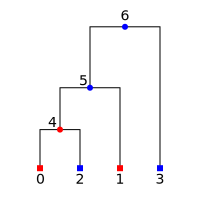

In [11]:
colour_map = {0:"red", 1:"blue"}
node_colours = {u.id: colour_map[u.population] for u in ts.nodes()}
for tree in ts.trees():
    print("Tree on interval:", tree.interval)
    # The code below will only work in a Jupyter notebook with SVG output enabled.
    display(SVG(tree.draw(node_colours=node_colours)))

More coalescences are happening in population 1 than population 0. This makes sense given that population 1 is specifying more migrants to population 0 than vice versa.

### Changing migration rates

(11.15am)

We can change any of the migration rates at any time in the simulation. To do this, we just need to use the msprime.Demography.add_migration_rate_change() method on our msprime.Demography object, specifying the populations whose migration rates are to be changed, the time of the change and the new migration rate.

For instance, say we wanted to specify that in each generation prior to time = 100, 1% of population 0 consisted of migrants from population 1.

In [ ]:
dem.add_migration_rate_change(time=100, rate=0.01, source=0, dest=1)
dem

The output above shows that we have successfully added our first demographic event to our msprime.Demography object, a migration rate change. We are now ready to simulate:

In [ ]:
ts = msprime.sim_ancestry(
  samples={"A" : 1, "B" : 1},
  demography=dem,
  sequence_length=1000,
  random_seed=63461,
  recombination_rate=1e-7)
ts

### Admixture

(11.25am)

It is also easy to specify admixture and divergence events with msprime. Suppose we wanted to specify our demography so that 50 generations ago, 30% of population 0 was a migrant from population 1:

We can do this by using the msprime.Demography.add_admixture() method on our demography object. We must supply a list of ancestral populations participating in the admixture, and a list of the same size specifying the proportions of migrants from each of these populations.

In [12]:
dem = msprime.Demography()
dem.add_population(name="AncestralPop0", description="Plotted in red.", initial_size=500, growth_rate=0)
dem.add_population(name="AncestralPop1", description="Plotted in blue.", initial_size=500, growth_rate=0)
dem.add_population(name="AdmixedPop", description="Plotted in green.", initial_size=500)
dem.set_migration_rate(source=0, dest=1, rate=0.05)
dem.set_migration_rate(source=1, dest=0, rate=0.02)

# Specify admixture event.
dem.add_admixture(time=50, derived="AdmixedPop", ancestral=["AncestralPop0", "AncestralPop1"], proportions=[0.3, 0.7]);

This simulates a sample where all nodes (ancestral haplotypes) are from the admixed population up until the time of the admixture event, and before this, all nodes are from one of the ancestral populations.

In [13]:
ts = msprime.sim_ancestry(
  samples={"AncestralPop0" : 0, "AncestralPop1" : 0, "AdmixedPop" : 6},
  demography=dem,
  sequence_length=1000,
  random_seed=63,
  recombination_rate=1e-7)

print("Populations of nodes from time < 50:")
print([u.population for u in ts.nodes() if u.time < 50])
print("Populations of nodes from time >= 50:")
print([u.population for u in ts.nodes() if u.time >= 50])

Populations of nodes from time < 50:
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Populations of nodes from time >= 50:
[1, 1, 1, 1, 0, 1, 1, 1, 0, 1]


Admixtures and population splits are special types of demographic events that affect the state of some of the defined populations, in addition to moving lineages between populations. The output below shows that by adding the admixture event, we are triggering a change in the state of AdmixedPop at time = 50; the population is active at the start of the simulation, but becomes inactive for all steps of the simulation beyond time 50.

In [14]:
dem

Demography(populations=[Population(initial_size=500, growth_rate=0, name='AncestralPop0', description='Plotted in red.', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0), Population(initial_size=500, growth_rate=0, name='AncestralPop1', description='Plotted in blue.', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1), Population(initial_size=500, growth_rate=0, name='AdmixedPop', description='Plotted in green.', extra_metadata={}, default_sampling_time=None, initially_active=None, id=2)], events=[Admixture(time=50, derived='AdmixedPop', ancestral=['AncestralPop0', 'AncestralPop1'], proportions=[0.3, 0.7])], migration_matrix=array([[0.  , 0.05, 0.  ],
       [0.02, 0.  , 0.  ],
       [0.  , 0.  , 0.  ]]))

This means that, for example, adding any demographic events that affect AdmixedPop beyond this time will produce an error:

In [ ]:
## THIS WON'T WORK
# dem.add_migration_rate_change(time=80, rate=0.01, source="AncestralPop0", dest="AdmixedPop");
# ts = msprime.sim_ancestry(
#   samples={"AncestralPop0" : 0, "AncestralPop1" : 0, "AdmixedPop" : 6},
#   demography=dem,
#   sequence_length=1000,
#   random_seed=63,
#   recombination_rate=1e-7)

To read more about the way that msprime treats the life cycle of populations, see here.

### Population splits

(11.25am)

We can also simulate population divergences with msprime. Suppose we want to model a situation where all lineages from multiple populations are migrants from a single ancestral population at a single point in time.

We’ll specify this with the msprime.Demography.add_population_split() method. We need to know the time of the event, and the IDs or labels of the derived and ancestral populations participating in the divergence event. Notice that in this case, we do not need to provide proportions as we did in the case of admixture. This makes sense when you think about the fact that msprime simulates backwards-in-time: all lineages in all of the derived populations originate from the ancestral population in a split event. Any differences in ‘quantities’ of migrants must be modelled by sizes of the derived populations at the time of the split.

In [ ]:
dem = msprime.Demography()
dem.add_population(name="A", description="Plotted in red.", initial_size=500)
dem.add_population(name="B", description="Plotted in blue.",initial_size=500)
dem.add_population(name="AncestralPopulation", description="Plotted in green.", initial_size=500)

# Add the population split.
dem.add_population_split(time=100, derived=["A","B"], ancestral="AncestralPopulation")
dem

Population splits will also modify the state of each of the derived populations, changing them from active to inactive at the time of the split.

In [ ]:
ts = msprime.sim_ancestry(
  samples={"A" : 3, "B" : 3, "AncestralPopulation" : 0},
  demography=dem,
  sequence_length=1000,
  random_seed=63,
  recombination_rate=1e-7)

print("Populations of nodes from time < 100:")
print([u.population for u in ts.nodes() if u.time < 100])
print("Populations of nodes from time >= 100:")
print([u.population for u in ts.nodes() if u.time >= 100])

### Changing population sizes or growth rates

(11.35am))

We may wish to specify changes to rates of population growth, or sudden changes in population size at a particular time. Both of these can be specified by applying the msprime.Demography.add_population_parameters_change() method to our msprime.Demography object.

In [ ]:
dem = msprime.Demography()
dem.add_population(name="A", description="Plotted in red.", initial_size=500)
dem.add_population(name="B", description="Plotted in blue.",initial_size=500)
dem.set_migration_rate(source=0, dest=1, rate=0.05)
dem.set_migration_rate(source=1, dest=0, rate=0.02)

# Bottleneck in Population 0 between 50 - 150 generations ago.
dem.add_population_parameters_change(time=50, initial_size=250, population=0)
dem.add_population_parameters_change(time=150, initial_size=500, population=0)

# Exponential growth in Population 1 starting 50 generations ago.
dem.add_population_parameters_change(time=100, growth_rate=0.01, population=1)

# Sort events, since we've added some out of time order.
dem.sort_events()

# Simulate.
ts = msprime.sim_ancestry(samples={"A" : 3, "B" : 3},
                          demography=dem, sequence_length=1000,
                          random_seed=63461,
                          recombination_rate=1e-7)

Note that because msprime simulates backwards-in-time, parameter changes must be interpreted backwards-in-time as well. For instance, the pop1_growth event in the example above specifies continual growth in the early history of population 1 up until 100 generations in the past.

## Debugging demography

(11.40am)

As we’ve seen, it’s pretty easy to make mistakes when specifying demography!

To help you spot these, msprime provides a debugger that prints out your population history in a more human-readable form. It’s good to get into the habit of running the msprime.DemographyDebugger before running your simulations.

my_history = msprime.DemographyDebugger(demography=dem)
my_history

## Other ancestry models

(11.45am)

When might the default (Hudson coalescent) model not be ideal for you?
 - Neutrality
 - Random mating and survival
 - Infinite population size
 - Infinite sites
 
 There may be situations where these assumptions are too restrictive for you. If you have particularly complicated requirements, you may wish move to SLiM. However, it is now possible to simulate with other models in msprime as well.

Default is Hudson, but have other options like Discrete-Time-Wright-Fisher (main features)

In [ ]:
# DTWF sim

Or simple model of genic selection at a single site using a structured-coalescent:

In [ ]:
Ne = 1e3
L = 1e6  # Length of simulated region
num_reps = 100

# define hard sweep model
sweep_model = msprime.SweepGenicSelection(
    position=L / 2,  # middle of chrom
    start_frequency=1.0 / (2 * Ne),
    end_frequency=1.0 - (1.0 / (2 * Ne)),
    s=0.25,
    dt=1e-6,
)

In [ ]:
# Run a small simulation and plot it, hopefully showcasing small trees?

## Mixing different ancestry models

(11.52am)

You can even run multiple models. (Can we simplify the code below?)

In [ ]:
random.seed(1234)
L = 100
Ne = 1e6

models = []
for _ in range(100):
    models.append(msprime.StandardCoalescent(duration=random.uniform(0, 1)))
    models.append(
        msprime.SweepGenicSelection(
            position=random.randint(1, L - 1),
            start_frequency=1 / (2 * Ne),
            end_frequency=1.0 - 1 / (2 * Ne),
            s=0.01,
            dt=1e-6,
        )
    )
models.append(msprime.StandardCoalescent())
models[:5]

In [ ]:
ts = msprime.sim_ancestry(
    10,
    population_size=100,
    sequence_length=L,
    recombination_rate=0.01,
    model=models,
    random_seed=6789
)
ts